# Aproximación de una Gaussiana con 1 qubit

[1] Adrián Pérez Salinas et al, Quantum 4, 226 (2020) https://quantum-journal.org/papers/q-2020-02-06-226/

Vamos a crear un modelo para aproximar una función $f(x)$ gaussiana con valores entre 0 y 1 (aproximadamente) con un solo qubit. Lo haremos siguiendo la idea del data reuploading, efectuando sucesivas rotaciones dependientes de x a un vector inicial $|0\rangle$. Para ello, lo primero que tenemos que tener es un muestreo de la Gaussiana, que lo haremos con numpy.

### Import necessary packages

In [ ]:
%load_ext line_profiler

In [1]:
# file: main_1D.py
# coding=UTF-8
from typing import Optional
import numpy as np
from numpy import pi
import matplotlib.style as style
import matplotlib.pyplot as plt
from scipy.optimize import minimize, check_grad
import scipy.integrate as integrate
import pickle
#from qiskit.algorithms.optimizers import SPSA
# from pathos.multiprocessing import ProcessingPool, cpu_count
# from mpi4py import MPI
# import dill
#from multiprocessing import Pool, cpu_count

## Creating the layers

Una vez que tenemos nuestra función, podemos comenzar a aproximarla. Dado vector en la base $\{(1,0),(0,1)\}$, que simbolizará un qubit en la base $|0\rangle,|1\rangle$, queremos obtener un vector dependiente de $x$ tal que la primera componenete codifique el valor de f(x). Dado un conjunto de ángulos $\phi_x$, $\phi_y$ y $\phi_z$, podemos parametrizar rotaciones en los ejes $x$, $y$, $z$ del cúbit en la esfera de Bloch. Estas rotaciones son matrices unitarias dadas por

$$R=\text{exp}\,\{i \,(\phi_x \sigma_x+\phi_y \sigma_y+\phi_z \sigma_z)\}=\text{exp}\,\{i \,\phi\,(n_x \sigma_x+n_y \sigma_y+n_z \sigma_z)\}\:,$$

Teniendo en cuenta que $\{\sigma_i,\sigma_j\}=2\delta_{ij}\mathbb{I}\:$ y $\:\sigma_i^2=\mathbb{I}$ deducimos que
$$(n_x \sigma_x+n_y \sigma_y+n_z \sigma_z)^2=\mathbb{I}\:.$$
Podemos reescribir la rotación como 
$$R=\mathbb{I}\,\cos{\phi}+i \,n\cdot\sigma \,\sin{\phi}$$

La identidad y las matrices de Pauli son

$$I = \begin{pmatrix}1 & 0 \\ 0 & 1 \end{pmatrix}\:,\qquad\sigma_x = \begin{pmatrix}0 & 1 \\ 1 & 0 \end{pmatrix}\:,\qquad \sigma_y = \begin{pmatrix}0 & -i \\ i & 0 \end{pmatrix}\:,\qquad \sigma_y = \begin{pmatrix}1 & 0 \\ 0 & -1 \end{pmatrix}$$


En nuestro caso, las rotaciones en el eje $x$ dependerán de un punto x de la malla en la que aproximamos la función, de forma que en cada capa de la red neuronal se vuelva a incluir esta información. Así, escogemos los ángulos 

$$\phi_1 = w\,\text{x} + \theta_0$$
$$\phi_2 = \theta_1 \qquad\:\,$$ 
$$\phi_3 = \theta_2 \qquad\:\,$$

ya que consideramos solo funciones de una variable.

## Creating our machine learning model

Each layer is an arbitrary unitary matrix
$$U_i(\phi_1, \phi_2, \phi_3) = \begin{pmatrix} \cos{(\phi_1/2)}\, e^{i(\phi_2+\phi_3)/2} & -\sin{(\phi_1/2)}\, e^{-i(\phi_2-\phi_3)/2} \\ \sin{(\phi_1/2)}\, e^{i(\phi_2-\phi_3)/2} & \cos{(\phi_1/2)}\, e^{-i(\phi_2+\phi_3)/2}  \end{pmatrix}$$

The following function returns the three rotations:

In [17]:
# file: main_1D.py
def layer(x: np.ndarray, θi: np.ndarray, wi: float) -> tuple:
    """
    Single qubit rotations.
    
    Parmeters
    ---------
    x : (G) array
        Grid of independent variables used to approximate the function.
    θ : (L,3) array
        Bias parameters of every layer.
    w : (L) array
        Weights of every layer.
    
    Returns
    -------
    A : (L,G,2,2) array
    Unitary matrices of each layer.
    
    References
    ----------
    [1] Adrián Pérez Salinas et al, "Data re-uploading for a universal
        quantum classifier Quantum" 4, 226 (2020)
        
    """
    if type(x) is float: G = 1
    else: G = x.size

    ϕ1 = wi*x+θi[0]*np.ones(G)
    ϕ2 = θi[1]*np.ones(G)
    ϕ3 = θi[2]*np.ones(G)

    Ui = np.asarray([[np.cos(ϕ1/2)*np.exp(1j*(ϕ2+ϕ3)/2), -np.sin(ϕ1/2)*np.exp(-1j*(ϕ2-ϕ3)/2)],
                    [np.sin(ϕ1/2)*np.exp(1j*(ϕ2-ϕ3)/2),np.cos(ϕ1/2)*np.exp(-1j*(ϕ2+ϕ3)/2)]])    
    return np.moveaxis(Ui, -1, 0)  # move last axis to the first position keeping the order of the rest axis

Otra alternativa de modelo estaría basada en las puertas de rotación 
$$R X(\theta)=\exp \left(-i \frac{\theta}{2} X\right)=\left(\begin{array}{cc}
\cos \frac{\theta}{2} & -i \sin \frac{\theta}{2} \\
-i \sin \frac{\theta}{2} & \cos \frac{\theta}{2}
\end{array}\right)$$
$$R Y(\theta)=\exp \left(-i \frac{\theta}{2} Y\right)=\left(\begin{array}{cc}
\cos \frac{\theta}{2} & -\sin \frac{\theta}{2} \\
\sin \frac{\theta}{2} & \cos \frac{\theta}{2}
\end{array}\right)$$
$$R Z(\lambda)=\exp \left(-i \frac{\lambda}{2} Z\right)=\left(\begin{array}{cc}
e^{-i \frac{\lambda}{2}} & 0 \\
0 & e^{i \frac{\lambda}{2}}
\end{array}\right)$$

In [18]:
# file: main_1D.py
def layer_rot(x: np.ndarray, θi: np.ndarray, wi: float) -> tuple:
    if type(x) is float: G = 1
    else: G = x.size

    ϕ1 = wi*x+θi[0]*np.ones(G)
    ϕ2 = θi[1]
    ϕ3 = θi[2]

    Rx = np.asarray([[np.cos(ϕ1/2), -1j*np.sin(ϕ1/2)],[-1j*np.sin(ϕ1/2), np.cos(ϕ1/2)]])
    Ry = np.array([[np.cos(ϕ2/2), -np.sin(ϕ2/2)],[np.sin(ϕ2/2), np.cos(ϕ2/2)]])
    Rz = np.array([[np.cos(ϕ3/2) - 1j*np.sin(ϕ3/2), 0],[0, np.cos(ϕ3/2)+1j*np.sin(ϕ3/2)]])

    Ui = np.einsum('mn,np,pqi->mqi', Rz, Ry, Rx)
    return np.moveaxis(Ui, -1, 0)  # move last axis to the first position keeping the order of the rest axis

We want the first component of $U|0\rangle=U_L \cdots U_1|0\rangle$ to approximate the function $f$:

$$f_{\text{approx}} = \langle 0 | U_L \cdots U_1 | 0 \rangle \:.$$

In the particular case the function is a probability distribution, we will return the $|0\rangle$ qubit's squared amplitude
$$f_{\text{approx}} = |\langle 0 | U_L \cdots U_1 | 0 \rangle|^2 $$

In [19]:
# file: main_1D.py
def evalua_modelo(x: np.ndarray, θ: np.ndarray, w: np.ndarray, probability=True, model = 'rotation'):
    """
    Given an array of unitaries, compute the function f(x) that
    it represents.
    
    Parameters
    ----------
    
    x : (L) array
        Points in the grid
    θ : (M, 3) array
        Variational parameters
    w : (M) array
        variational parameters
    probability : True if f(x) >= 0
    
    Returns
    -------
    fi : estimate of f(xi) on all elements of 'x'
    
    """
    L = w.size
    if model == 'rotation':
        U = layer_rot(x, θ[:,0], w[0])[:,:,0]
        for i in range(1,L):
            Ui = layer_rot(x, θ[:,i], w[i])
            U = np.einsum('imn,in->im', Ui, U)
    else:  
        U = layer(x, θ[:,0], w[0])[:,:,0]
        for i in range(1,L):
            Ui = layer(x, θ[:,i], w[i])
            U = np.einsum('imn,in->im', Ui, U)
            
    return (U[:,0]*np.conjugate(U[:,0])).real if probability else U[:,0]

Now we create the cost function that approximates our model. Is is a simple mean square error:

$$C = \frac{1}{G}\sum_{x} |f_{\text{approx}}(x,w,\theta) - f(x)|^2$$

where $G$ is the size of the grid that approximates the function.

In [20]:
# file: main_1D.py
def coste(x, f, θ, w, probability = True, model = 'rotation'):
    """Cost function of the model.
    
    Parameters
    ----------
    x : (G) array
        Points in the grid
    f : (G) array
        Points of the function evaluated in the grid
    θ : (M, 3) array
        Variational bias parameter.
    w : (M) array
        Variational weight parameters.
    probability : bool
        Function is a probability density.
        
    Returns
    -------
    (L) array with the mean square error for each x in the grid.
        
    """
    f_approx = evalua_modelo(x, θ, w, probability, model = model)
    return np.mean(np.abs(f_approx - f)**2)

## Derivative Cost Function

Now that we have our cost function and neural net working, we want to improve it adding an analytic gradient function to the minimizer. In the case the function is not a probability density, it is encoded in the probability amplitud of the $|0\rangle$ qubit, $f_{\text{approx}} = \langle 0 | U | 0 \rangle$, and the cost function is

$$C = \frac{1}{G}\sum_{x} |\langle 0 | U(x,w,\theta) | 0 \rangle - f(x)|^2 \:.$$

Taking the derivative respect to the parameter $\lambda_i$ of the $i$-th layer

$$\frac{\partial C}{\partial \lambda_i} = \frac{1}{G}\sum_{x} 2\, \text{Re}\bigg\{\big(\langle 0 | U(x,w,\theta) | 0 \rangle - f(x)\big)\,\frac{\partial \langle 0 | U(x,w,\theta) | 0 \rangle}{\partial \lambda_i}\bigg\} = $$

$$ = \frac{1}{G}\sum_{x} 2\, \text{Re}\bigg\{\big(\langle 0 | U(x,w,\theta) | 0 \rangle - f(x)\big)\,\langle 0 |U_L \cdots \frac{\partial  U_i(x,w_i,\theta_i)} {\partial \lambda_i} \cdots U_1 | 0 \rangle \bigg\} \:. $$

To calculate the derivatives of the rotations easily, we derive the previous formula 

$$\frac{\partial U_i}{\partial w} = \frac{1}{2}\begin{pmatrix} \cos{(\phi_1/2+\pi/2)}\, e^{i(\phi_2+\phi_3)/2} & -\sin{(\phi_1/2+\pi/2)}\, e^{-i(\phi_2-\phi_3)/2} \\ \sin{(\phi_1/2+\pi/2)}\, e^{i(\phi_2-\phi_3)/2} & \cos{(\phi_1/2+\pi/2)}\, e^{-i(\phi_2+\phi_3)/2}  \end{pmatrix}\frac{\partial \phi_1}{\partial w} = \frac{1}{2}U_i(\phi_1+\pi,\phi_2,\phi_3)\,x$$

$$\frac{\partial U_i}{\partial \theta_0} = \frac{1}{2}U_i(\phi_1+\pi,\phi_2,\phi_3)$$

$$\frac{\partial U_i}{\partial \theta_1} = \frac{1}{2}U_i(\phi_1,\phi_2+\pi,\phi_3)$$

$$\frac{\partial U_i}{\partial \theta_2} = \frac{1}{2}U_i(\phi_1,\phi_2,\phi_3+\pi)$$

Taking the derivative respect to the parameter $\lambda_i$ of the $i$-th layer

$$\frac{\partial C}{\partial \lambda_i} = \frac{1}{G}\sum_{x} 2\, \text{Re}\bigg\{\big(\langle 0 | U(x,w,\theta) | 0 \rangle - f(x)\big)\,\frac{\partial \langle 0 | U(x,w,\theta) | 0 \rangle}{\partial \lambda_i}\bigg\} = $$

$$ = \frac{1}{G}\sum_{x} 2\, \text{Re}\bigg\{\big(\langle 0 | U(x,w,\theta) | 0 \rangle - f(x)\big)\,\langle 0 |U_L \cdots \frac{\partial  U_i(x,w_i,\theta_i)} {\partial \lambda_i} \cdots U_1 | 0 \rangle \bigg\} \:. $$

In [21]:
# file: main_1D.py
def der_layer(x: np.ndarray, θi: np.ndarray, wi: float, model = 'rotation') -> tuple:
    if type(x) is float: G = 1
    else: G = x.size
    
    if model == 'rotation':
        ϕ1 = wi*x+θi[0]*np.ones(G)
        ϕ2 = θi[1]
        ϕ3 = θi[2]

        Rx = np.asarray([[np.cos(ϕ1/2), -1j*np.sin(ϕ1/2)],[-1j*np.sin(ϕ1/2), np.cos(ϕ1/2)]])
        Ry = np.array([[np.cos(ϕ2/2), -np.sin(ϕ2/2)],[np.sin(ϕ2/2), np.cos(ϕ2/2)]])
        Rz = np.array([[np.cos(ϕ3/2) - 1j*np.sin(ϕ3/2), 0],[0, np.cos(ϕ3/2)+1j*np.sin(ϕ3/2)]])

        DRx = 1/2*np.asarray([[-np.sin(ϕ1/2), -1j*np.cos(ϕ1/2)],[-1j*np.cos(ϕ1/2), -np.sin(ϕ1/2)]])
        DRy = 1/2*np.array([[-np.sin(ϕ2/2), -np.cos(ϕ2/2)],[np.cos(ϕ2/2), -np.sin(ϕ2/2)]])
        DRz = 1/2*np.array([[-1j*np.cos(ϕ3/2) - np.sin(ϕ3/2), 0],[0, 1j*np.cos(ϕ3/2)-np.sin(ϕ3/2)]])

        Dx = np.einsum('mn,np,pqi->imq', Rz, Ry, DRx)
        Dw = np.einsum('mn,np,pqi,i->imq', Rz, Ry, DRx, x)
        Dy = np.einsum('mn,np,pqi->imq', Rz, DRy, Rx)
        Dz = np.einsum('mn,np,pqi->imq', DRz, Ry, Rx)
        
    else:
        Dx = 1/2*layer(x, np.array([θi[0]+np.pi, θi[1], θi[2]]), wi)
        Dw = np.einsum("imn,i->imn", Dx, x)
        Dy = 1/2*layer(x, np.array([θi[0], θi[1]+np.pi, θi[2]]), wi)
        Dz = 1/2*layer(x, np.array([θi[0], θi[1], θi[2]+np.pi]), wi)

    return np.array([Dw, Dx, Dy, Dz])

Now we create a function to calculate 

$$\langle 0 | \,U_L \cdots \frac{\partial U_i }{\partial \lambda_i}\cdots U_1\,| 0 \rangle$$

The program will return an array with layers in the first index, parameter of each layer in the second index and x in the third index. 

We do it recursively with two loops. First an ascending loop:

1. Step 1

$$ D[1] = \frac{\partial U_1 }{\partial \lambda_j}$$

$$ A = U_1$$

2. Step 2

$$ D[2] = \frac{\partial U_2 }{\partial \lambda_j}A = \frac{\partial U_2 }{\partial \lambda_j} U_1$$

$$ A = U_2 A = U_2 U_1 $$

3. Step 3

$$ D[3] = \frac{\partial U_2 }{\partial \lambda_j}A = \frac{\partial U_3 }{\partial \lambda_j} U_2 U_1$$

$$ A = U_3 A = U_3 U_2 U_1$$

$$\vdots$$

4. Step i

$$ D[i] = \frac{\partial U_n }{\partial \lambda_j}A $$

$$ A = U_i A$$

And then a descending loop (L is the last index):

1. Step 1

$$ D[L-1] = U_L D[L-1] = U_L \cdots \frac{\partial U_i }{\partial \lambda_i}\cdots U_1 $$

$$ B = U_L U_{L-1}$$

2. Step 2

$$ D[L-2] = B D[L-2] = U_L U_{L-1} \frac{\partial U_{L-2} }{\partial \lambda_j} \cdots U_1$$

$$ B = B \,U_{L-2} = U_L U_{L-1} U_{L-2} $$

$$\vdots$$

4. Step i

$$ D[i] = B \frac{\partial U_i }{\partial \lambda_j} = U_L\cdots U_{i+1} \frac{\partial U_i }{\partial \lambda_j}\cdots U_1 $$

$$ B = B U_i = U_L \cdots U_i$$


In [22]:
# file: main_1D.py

def der_net(x: np.ndarray, θ: np.ndarray, w: np.ndarray, model = 'rotation'):
    """"Create recursively the derivatives with respect to each parameter of the entire net. """
    
    L = w.size
    G = x.size
    A = np.tensordot(np.ones(G), np.identity(2), axes=0)  # dim (G,2,2)
    D = np.zeros((L,4,G,2,2), dtype=np.complex128)
    
    for i in range(L):  
        DUi = der_layer(x, θ[:,i], w[i], model = model) # dim (4,G,2,2)
        D[i,...] = np.einsum('jimn,inp->jimp', DUi, A)  # j es cada una de las derivadas
        # Multiply derivative times next layer
        if model == 'rotation':
            Ui = layer_rot(x, θ[:,i], w[i])
        else:
            Ui = layer(x, θ[:,i], w[i])
        A = np.einsum('imn,inp->imp', Ui, A)
    
    # En la primera iteración reaprovechamos el Ui de la capa L
    B = Ui
    
    for i in range(L-2,-1,-1):
        D[i,...] = np.einsum('imn,jinp->jimp', B, D[i,...]) 
        # Multiply derivative times previous layer
        if model == 'rotation':
            Ui = layer_rot(x, θ[:,i], w[i])
        else: 
            Ui = layer(x, θ[:,i], w[i])
        B = np.einsum('imn,inp->imp', B, Ui)
     # D is shape (L,4,G,2,2). We also return the model
    return D, A 


If we approximate an arbitrary complex function, the cost function is 

$$ C = \frac{1}{G} \sum_{x} |\,\langle 0 | U(x,w,\theta) | 0 \rangle - f(x) \,|^{\,2} \:,$$

and its derivative is

$$\frac{\partial C}{\partial \lambda_i} =\frac{1}{G} \sum_{x} 2 \,\text{Re}\,\Big\{ \big(\langle 0 | U(x,w,\theta) | 0 \rangle - f(x) \big)^\ast \, \frac{\partial \langle 0 | U | 0 \rangle}{\partial \lambda_i}\Big\} = $$

$$=\frac{1}{G} \sum_{x} 2 \,\text{Re}\,\Big\{ \big(\langle 0 | U(x,w,\theta) | 0 \rangle - f(x) \big)^\ast \,  \langle 0 | \,U_L \cdots \frac{\partial U_i }{\partial \lambda_i}\cdots U_1\,| 0 \rangle\Big\}$$

If we approximate a probability density function instead, the cost function is 

$$ C = \frac{1}{G} \sum_{x} \Big(|\langle 0 | U(x,w,\theta) | 0 \rangle|^2 - f(x)\Big)^2 \:.$$

Then, the derivative of the cost function respect $\lambda_i$ is

$$\frac{\partial C}{\partial \lambda_i} = \frac{1}{G} \sum_{x} 2\,\big(|\langle 0 | U(x,w,\theta) | 0 \rangle|^2 - f(x)\big)\,2\,\text{Re}\,\Big\{\langle 0 | U | 0 \rangle^\ast \, \frac{\partial \langle 0 | U | 0 \rangle}{\partial \lambda_i}\Big\} = $$

$$ = \frac{1}{G} \sum_{x} 4\,\big(|\langle 0 | U(x,w,\theta) | 0 \rangle|^2 - f(x)\big)\,\text{Re}\,\Big\{\langle 0 | U | 0 \rangle^\ast \, \langle 0 | \,U_L \cdots \frac{\partial U_i }{\partial \lambda_i}\cdots U_1\,| 0 \rangle\Big\} $$

In [23]:
# file: main_1D.py
def der_coste(x, f, θ, w, probability = True, return_cost = False, model = 'rotation'):
    """"Returns the gradient of the cost function with respect to each parameter. """
    
    L = w.size
    G = x.size

    if probability:
        ders, A = der_net(x, θ, w, model = model)
        U = A[:,0,0]
        E = U*np.conj(U) - f
        # índice i layers, j parametro 
        der_C = 4/G * np.array([[np.dot(E.real, np.real(np.conj(U)*ders[i,j,:,0,0])) for i in range(L)] for j in range(4)])

    else:
        ders, A = der_net(x, θ, w, model = model)
        U = A[:,0,0]
        E = U - f   # error in approximation
        der_C = 2/G * np.array([[np.real(np.dot(np.conj(E), ders[i,j,:,0,0])) for i in range(L)] for j in range(4)])
        
    # devolvemos un array con la misma estructura que ϕ = [w, θ_0, θ_1, θ_2]
    if return_cost:
        if probability:
            return der_C.flatten(), np.mean((np.abs(U*np.conjugate(U)).real - f)**2)
        else:
            return der_C.flatten(), np.mean(np.abs(U - f)**2)
    else: return der_C.flatten() 

## Función de coste alternativa

Probamos a usar la función de coste alternativa

$$C = \frac{1}{\sqrt{G}}\sqrt{\sum_{x} |f_{\text{approx}}(x,w,\theta) - f(x)|^2}$$


In [24]:
# file: main_1D.py
def coste_sqrt(x, f, θ, w, probability, model = 'rotation'):
    """Cost function of the model.
    
    Parameters
    ----------
    x : (G) array
        Points in the grid
    f : (G) array
        Points of the function evaluated in the grid
    θ : (M, 3) array
        Variational bias parameter.
    w : (M) array
        Variational weight parameters.
    probability : bool
        Function is a probability density.
        
    Returns
    -------
    (L) array with the mean square error for each x in the grid.
        
    """
    return np.sqrt(coste(x, f, θ, w, probability = probability, model = model))

La derivada será

$$\frac{\partial C}{\partial \lambda_i} = \frac{1}{\sqrt{G}} \frac{1}{\sqrt{\sum_{x}|f_{\text{approx}}(x,w,\theta) - f(x)|^2}} \sum_{x}\,\text{Re}\,\Big\{ \big(\langle 0 | U(x,w,\theta) | 0 \rangle - f(x) \big)^\ast \,  \langle 0 | \,U_L \cdots \frac{\partial U_i }{\partial \lambda_i}\cdots U_1\,| 0 \rangle\Big\}$$

In [25]:
# file: main_1D.py
def der_coste_sqrt(x, f, θ, w, probability = True, return_cost = False, model = 'rotation'):
    """"Returns the gradient of the cost function with respect to each parameter. """
    
    L = w.size
    G = x.size

    if probability:
        ders, A = der_net(x, θ, w, model = model)
        U = A[:,0,0]
        E = (U*np.conj(U)).real - f
        # índice i layers, j parametro 
        der_C = 2/(np.sqrt(G)*np.sqrt(np.sum(np.abs(E)**2)+1e-9)) * np.array([[np.dot(E, np.real(np.conj(U)*ders[i,j,:,0,0])) for i in range(L)] for j in range(4)])

    else:
        ders, A = der_net(x, θ, w, model = model)
        U = A[:,0,0]
        E = U - f   # error in approximation
        der_C = 1/(np.sqrt(G)*np.sqrt(np.sum(np.abs(E)**2)+1e-9)) * np.array([[np.real(np.dot(np.conj(E), ders[i,j,:,0,0])) for i in range(L)] for j in range(4)])
        
    # devolvemos un array con la misma estructura que ϕ = [w, θ_0, θ_1, θ_2]
    if return_cost:
        if probability:
            return der_C.flatten(), np.mean((np.abs(U*np.conjugate(U)).real - f)**2)
        else:
            return der_C.flatten(), np.mean(np.abs(U - f)**2)
    else: return der_C.flatten() 

In [47]:
from exportnb import *

In [48]:
export_notebooks(['main_1D.ipynb'], verbose=True)

Reading notebook main_1D.ipynb
Exporting file main_1D.py


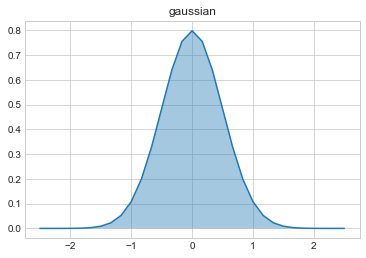

In [35]:
Test = Test_Functions()
x, f = Test.plot(31, 'gaussian', interval = (-1,1), show_plot = True)

In [45]:
def coste_intermedio(φ):
    ω, θ = split(φ)
    return coste_sqrt(x, f, θ, ω, True, model = 'rotation')

def der_coste_intermedio(φ):
    ω, θ = split(φ)
    return der_coste_sqrt(x, f, θ, ω, True, model = 'rotation')

In [46]:
layers = 5
φ = np.asarray([-1,-3,4,5,2,8,0,0,1,3,0,1,2,3,6,9,0,1,3,6])
check_grad(coste_intermedio, der_coste_intermedio, φ)

2.1608822777560752e-08

## Training the model

Once we have our cost function and its gradient, we can train our machine learning model. We will use the optimization algorithm L-BFGS-B to minimize the cost function. The algorithm will take as input the array 

$$\phi = [w, \theta_0, \theta_1, \theta_2]\:,$$

with the parameters of the model.

In [26]:
# file: main_1D.py
def split(φ):
    layers = φ.size // 4
    return φ[0:layers], φ[layers:].reshape(3, layers)

Optimizador con los métodos predispuestos en ``scipy``. 

In [18]:
# file: main_1D.py
def blackbox_minimizer(x, f, φ_init, probability: bool,
             opt_method: str = 'L-BFGS-B', print_cost: bool = False, cost_fun = 'sqrt', model = 'rotation'):
    
    if cost_fun == 'sqrt':
        cost_function = globals()["coste_sqrt"]
        der_cost_function = globals()["der_coste_sqrt"]
    elif cost_fun == 'normal':
        cost_function = globals()["coste"]
        der_cost_function = globals()["der_coste"]

    def coste_intermedio(φ):
        w, θ = split(φ)
        c = cost_function(x, f, θ, w, probability, model = model)
        if print_cost:  print('Valor f. coste: ', c)
        return c

    def der_coste_intermedio(φ):
        w, θ = split(φ)
        der_c = der_cost_function(x, f, θ, w, probability, model = model)
        if print_cost:  print('Valor der. coste: ', der_c)
        return der_c

    return minimize(coste_intermedio, φ_init, method = opt_method, jac = der_coste_intermedio, tol = 1e-12, options={'maxiter': 10000})

In [ ]:

def spsa_minimizer(x, f, φ_init, probability: bool, print_cost: bool = False, cost_fun = 'sqrt'):
    
    if cost_fun == 'sqrt':
        cost_function = globals()["coste_sqrt"]
    elif cost_fun == 'normal':
        cost_function = globals()["coste"]

    def coste_intermedio(φ):
        w, θ = split(φ)
        c = cost_function(x, f, θ, w, probability)
        if print_cost:  print('Valor f. coste: ', c)
        return c

    spsa = SPSA(maxiter=20000)
    return spsa.optimize(φ_init.size, coste_intermedio, initial_point=φ_init)[0]

Now we program the ADAM optimizer

In [19]:
# file: main_1D.py
def adam_minimizer(x, f, φ, probability: bool, print_cost: bool = True, plot_cost = False, cost_fun = 'sqrt', model = 'rotation', n_iter = 800,
		 alpha = 0.01, beta1 = 0.9, beta2 = 0.999, eps=1e-8):
	'''
	Parameters
	----------
	n_iter : int
        Number of iterations of the optimization algorithm
    alpha : float
        steps size
    beta1 : float
        factor for average gradient
	beta2 : float
		factor for average squared gradient

	'''
	if cost_fun == 'sqrt':
		der_cost_function = globals()["der_coste_sqrt"]
	elif cost_fun == 'normal':
		der_cost_function = globals()["der_coste"]

	num_params = φ.size
	# initialize first and second moments
	m = np.zeros(num_params)
	v = np.zeros(num_params)
	# Model parameters
	min_cost = 10
	cost = np.zeros(n_iter)
	for t in range(n_iter):
		w, θ = split(φ)
		# g, cost = der_coste(x, f, θ, w, probability, return_cost = True)
		g, cost[t] = der_cost_function(x, f, θ, w, probability, return_cost = True, model = model)
		if cost[t] < min_cost: 
			min_cost = cost[t]
			min_t = t
			min_φ = φ
		if print_cost:
			print('φ = {φ}  ,  cost = {cost}'.format(φ = φ, cost = cost[t]))
		m = beta1 * m + (1.0 - beta1) * g
		v = beta2 * v + (1.0 - beta2) * g**2
		mhat = m / (1.0 - beta1**(t+1))
		vhat = v / (1.0 - beta2**(t+1))
		φ = φ - alpha * mhat / (np.sqrt(vhat) + eps)
	# print('El coste mínimo alcanzado es {min_cost} en la iteración {min_t}.'.format(min_cost=min_cost, min_t=min_t))
	# Devolvemos el φ que minimiza la función de coste
	if plot_cost:
		plt.plot(range(n_iter), cost)
		plt.yscale('log')
		plt.show()
	return min_φ

In [20]:
# file: main_1D.py
def train_perceptron(x: np.ndarray, f: np.ndarray,
                     layers: int = 4,
                     opt_method: str = 'L-BFGS-B',
                     method_params: dict = {'n_iter': 800, 'alpha': 0.01, 'beta1': 0.9, 'beta2': 0.999, 'eps': 1e-8},
                     seed: float = 2.0,
                     φ_init: Optional[np.ndarray] = None,
                     print_cost: bool = False,
                     show_plot = True,
                     cc = 0.3,
                     probability: Optional[np.ndarray] = None,
                     plot_cost: bool = False,
                     cost_fun: str = 'sqrt',
                     plot_title: str = '',
                     model = 'rotation' ):

    if φ_init is None:
        np.random.seed(seed) 
        φ_init = cc*np.random.randn(layers + 3*layers)

    if probability is None:
        probability = (f >= 0).all()
    
    if opt_method == 'ADAM':
        φ = adam_minimizer(x,f, φ_init, probability = probability, print_cost = print_cost, plot_cost = plot_cost,
                    cost_fun = cost_fun, model = model, **method_params)
        result = 0  # resultado a 0 por defecto en este método
    elif opt_method == 'SPSA':
        φ = spsa_minimizer(x, f, φ_init, probability = probability,
        print_cost = print_cost, cost_fun = cost_fun)
        result = 0
    else:
        result = blackbox_minimizer(x, f, φ_init, opt_method = opt_method, probability = probability,
        print_cost = print_cost, cost_fun = cost_fun, model = model)
        φ = result.x

    if show_plot:
        ω, θ = split(φ) 
        f_approx = evalua_modelo(x, θ, ω, probability, model = model)
        plt.close('all')
        plt.plot(x, f)
        plt.plot(x, f_approx.real)
        plt.title(plot_title)
        plt.show()
    
    return φ, result

## Class of functions to approximate

In [32]:
# file: main_1D.py
class Test_Functions:
    '''Usamos mayúslas para denotar clases y minúsculas para atributos.'''
    def __init__(self):
        style.use(['seaborn-whitegrid'])

    def gaussian(x: np.ndarray , mean: float = 0.0, std: float = 0.2, coef = 1):
        """
        Approximate and plot a gaussian function.
    
        Parameters 
        ----------
        x : np.ndarray
            Grid in which to approximate the function.
        mean : float 
            Mean of the gaussian.
        std : float
            Standard deviation.
        coef : float
            Factor that multiplies the gaussian.
    
        Returns
        -------
        f : Function
    
        """
        if coef is None:
            coef = (1/(std*np.sqrt(2*pi)))
        return coef*np.exp(-(x-mean)**2/(2*std**2))
    def lorentzian(x: np.ndarray, x0: float = 0.0, γ: float = 0.2, coef = None):
        if coef is None:
            coef = γ
        return coef*γ/((x-x0)**2+γ**2)
    def sine(x: np.ndarray, a: float = 1.0, b: float = 0.0):
        return np.sin(a*x+b)
    def cos(x: np.ndarray, a: float = 1.0, b: float = 0.0):
        return np.cos(a*x+b)
    def step(x: np.ndarray, b: float = 0.0, coef: float = 1.0):
        return coef*np.heaviside(x, b)
    def relu(x: np.ndarray, a: float = 1.0):
        if a<=0: raise ValueError('a must be a positive constant')
        return np.maximum(0,a*x)
    def tanh(x: np.ndarray, a: float = 5.0, coef = 1.0):
        return coef*np.tanh(a*x)
    def poly(x: np.ndarray):
        return -4*x**2*(x**2-1)
    def poly2(x: np.ndarray):
        return np.abs((1-x**4)*3*x**3)
    def cos2_sin2(x: np.ndarray, a: float = 1.0, b: float = 0.0):
        return np.cos(a*x+b)**2-np.sin(a*x+b)**2

    def plot(self, grid_size: int = 31,
            function: str = 'gaussian',
            params: dict = {'mean': 0.0, 'std': 0.5, 'coef': None},
            interval: tuple = (-1,1),
            show_plot = True):

        if function == 'gaussian':
            x = np.linspace(params['mean']-5*params['std'], params['mean']+5*params['std'], grid_size)
        else:
            x = np.linspace(interval[0], interval[1], grid_size) 
        fun = getattr(Test_Functions, function)
        f = fun(x, **params)

        if show_plot:
            plt.close('all')
            plt.plot(x,f)
            plt.title(function)
            plt.show()
        return x, f
        

## Errores

Calculamos diferentes errores, como norma L2, L1, norma infinito o la fidelidad:

$$\text{Error\_L1} = \big| \int f_{\text{approx}} - f \big|\Big/\int|f|  $$
$$\text{Error\_L2} = \sqrt{\int \big| f_{\text{approx}} - f \big|^2}\Big/ \sqrt{\int f^2}  $$
$$\text{Error\_max} = \text{max}\,(f-f_{\text{approx}}) $$
$$\text{Fid} = |\langle\hat{f}|\hat{f}_{\text{approx}}\rangle|^2 = \big|\int f_{\text{approx}}\cdot f \big|^2 \Big/ \int f^2 \cdot \int f_{\text{approx}}^2 $$

In [ ]:
# file: main_1D.py
def error_perceptron(φ: np.ndarray,
                    function: str = 'gaussian',
                    f_params: dict = {'mean': 0.0, 'std': 0.5, 'coef': None},
                    interval: tuple = (-1,1),
                    method: str = 'quad',
                    probability: bool = True,
                    model = 'rotation'):
    """"
    Error in the approximation of the function by the qubit perceptron.
    Returns the error measured in different norms.
    
    """
    layers = φ.size // 4
    w, θ = φ[0:layers], φ[layers:].reshape(3, layers)

    # Seleccionamos la función a aproximar
    fun = getattr(Test_Functions, function)
    # Norma L2
    diff_l2 = lambda x: (np.abs(fun(x, **f_params) - evalua_modelo(x, θ, w, probability, model = model)))**2
    f2_theo = lambda x: fun(x, **f_params)**2
    # Norma L1
    diff_abs = lambda x: np.abs(fun(x, **f_params) - evalua_modelo(x, θ, w, probability, model = model))
    f_theo_abs = lambda x: np.abs(fun(x, **f_params))
    # Fidelity (no hace falta conjugar f porque el modelo es real)
    prod_re = lambda x: np.real(fun(x, **f_params)*evalua_modelo(x, θ, w, probability, model = model))
    prod_im = lambda x: np.imag(fun(x, **f_params)*evalua_modelo(x, θ, w, probability, model = model))
    f2_approx = lambda x: np.abs(evalua_modelo(x, θ, w, probability, model = model))**2
    # Norma infinito
    y = np.linspace(interval[0], interval[1], 10000)
    error_inf = np.max(np.abs(fun(y, **f_params) - evalua_modelo(y, θ, w, probability, model = model)))
    # Seleccionamos el método de integración
    if method == 'simpson':
        # L2 calculation
        error_l2 = np.sqrt(integrate.simpson(diff_l2(y), y)) #/np.sqrt(integrate.simpson(f2_theo(y), y))
        # L2 calculation
        error_l1 = integrate.simpson(diff_abs(y), y) #/integrate.simpson(f_theo_abs(y), y)
        # Fidelity calculation
        int_prod_squared = integrate.simpson(prod_re(y), y)**2+integrate.simpson(prod_im(y), y)**2
        error_infid = 1-int_prod_squared/(integrate.simpson(f2_approx(y), y) * integrate.simpson(f2_theo(y), y))
        return error_l2, error_l1, error_inf, error_infid
        
    elif method == 'quad':
        error_l2 = np.sqrt(integrate.quad(diff_l2, interval[0], interval[1], limit=300)[0])
        error_l1 = integrate.quad(diff_abs, interval[0], interval[1], limit=300)[0]
        int_prod_squared = integrate.quad(prod_re, interval[0], interval[1], limit=300)[0]**2+integrate.quad(prod_im, interval[0], interval[1], limit=300)[0]**2
        error_infid = 1 - int_prod_squared/(integrate.quad(f2_approx, interval[0], interval[1], limit=300)[0] * integrate.quad(f2_theo, interval[0], interval[1], limit=300)[0])
        return error_l2, error_l1, error_inf, error_infid
    else:
        raise ValueError('Solo está permitido usar quad o simpson para la integral.')

In [ ]:
# file: main_1D.py
def plot_errores(layer_list, l2_list, l1_list, inf_list, infid_list, cost_error, function):
    plt.close('all')
    fig, ax = plt.subplots(1,1)
    ax.plot(layer_list, l2_list, linestyle='-', marker='o', markersize = 6, color='#1f77b4', label='L2 norm')
    ax.plot(layer_list, l1_list, linestyle='-', marker='^', markersize = 6, color='#ff7f0e', label='L1 norm')
    ax.plot(layer_list, inf_list, linestyle='-', marker='D',markersize = 6, color='#2ca02c', label='Infinity norm')
    ax.plot(layer_list, infid_list, linestyle='-', marker='*',markersize = 6, color='crimson', label='Infidelity')
    ax.plot(layer_list, cost_error, linestyle='-', marker='*',markersize = 6, color='olive', label='Coste')
    

    ax.set_title('Error vs Number of layers (' + function + ')')
    ax.set_xlabel('Layers')
    ax.set_ylabel('Error')
    ax.legend(loc='upper right', fontsize='large')
    plt.yscale('log')
    plt.show()

In [ ]:
# file: main_1D.py
def graficas_errores(seed, min_layers, max_layers,
                    x: Optional[np.ndarray] = None,
                    f: Optional[np.ndarray] = None,
                    grid_size: int = 31,
                    function: str = 'gaussian',
                    f_params: dict = {'mean': 0.0, 'std': 2, 'coef': 1},
                    interval: tuple = (-1,1),
                    int_method: str = 'quad',
                    opt_method: str = 'L-BFGS-B',
                    φ_init: Optional[np.ndarray] = None,
                    probability: Optional[bool] = None,
                    show_plot: bool = False,
                    show_final_plot: bool = True,
                    show_error_plot: bool = True,
                    show_diff = False,
                    print_cost: bool = False,
                    cost_fun: str = 'sqrt',
                    incremental_opt: bool = True,
                    print_params: bool = False,
                    cc: float = 0.3,
                    new_layer_position: str = 'random',
                    new_layer_coef: float = 0.2,
                    plot_cost_error: bool = False,
                    model = 'rotation',
                    method_params: dict = {'n_iter': 800, 'alpha': 0.01, 'beta1': 0.9, 'beta2': 0.999, 'eps': 1e-8}):
    
    Test = Test_Functions()
    l2_list, l1_list, inf_list, infid_list = [], [], [], []
    layer_list = list(range(min_layers, max_layers+1))

    if x is None and f is None:
        x, f = Test.plot(grid_size, function, f_params, interval = interval, show_plot = show_plot)
    if probability is None:
        probability = (f >= 0).all()
    
    np.random.seed(seed)
    if φ_init is None:
        # cc deberá ser un valor pequeño en principio
        φ = cc * np.random.randn(min_layers + 3*min_layers)
        if print_params: print('Parámetros iniciales: ', φ)
    else: φ = φ_init

    mean_diff = np.zeros(max_layers-min_layers)
    std_diff = np.zeros(max_layers-min_layers)
    cost_error = np.zeros(max_layers-min_layers+1)

    for i, layer in enumerate(layer_list):
        φ, result = train_perceptron(x, f, layers = layer, probability = probability, opt_method = opt_method , seed = seed,
                                 φ_init = φ, show_plot = show_plot, method_params = method_params, print_cost = print_cost,
                                 plot_title = function + ' optimized with ' + opt_method, cost_fun = cost_fun, model = model)
        # print('Los parámetros óptimos en la capa {layer} son {φ}.\n'.format(layer = layer, φ=φ))
        error_l2, error_l1, error_inf, error_infid = error_perceptron(φ, function, f_params, interval, int_method, probability, model = model)
        
        ω, θ = split(φ)
        cost_error[i] = coste(x,f,θ,ω,probability, model = model)
        # Guardamos la diferencia entre el φ optimizado de la anterior capa y de esta
        if layer > min_layers:
            if new_layer_position == 'final':
                diff_φ = φ.reshape(4,layer).T.flatten()[0:4*(layer-1)] - φ_old.reshape(4,layer-1).T.flatten()
                mean_diff[i-1] = np.mean(np.abs(diff_φ))
                std_diff[i-1] = np.std(np.abs(diff_φ))
            elif new_layer_position == 'initial':
                diff_φ = φ.reshape(4,layer).T.flatten()[4:4*layer] - φ_old.reshape(4,layer-1).T.flatten()
                mean_diff[i-1] = np.mean(np.abs(diff_φ))
                std_diff[i-1] = np.std(np.abs(diff_φ))
        φ_old = φ

        l2_list.append(error_l2)
        l1_list.append(error_l1)
        inf_list.append(error_inf)
        infid_list.append(error_infid)

        if layer == max_layers:
            if show_final_plot:
                ω, θ = φ[0:layer], φ[layer:].reshape(3, layer) 
                f_approx = evalua_modelo(x, θ, ω, probability, model = model)
                plt.close('all')
                plt.plot(x, f)
                plt.plot(x, f_approx.real)
                plt.title(function + ' optimization with ' + opt_method)
                plt.show()
            break
        if incremental_opt is True:
            # Inicializamos una nueva capa en la posición indicada
            if new_layer_position == 'random':
                i = np.random.randint(0, high=layer+1, dtype=int)
            elif new_layer_position == 'final':
                i = layer
            elif new_layer_position == 'initial':
                i = 0
            elif new_layer_position == 'middle':
                i = min_layers + (layer-min_layers)//2 
            else: raise ValueError('El valor de new_layer_position = {a} no es válido.'.format(a = new_layer_position))
            # Añadimos la nueva capa con valores cercanos a 0
            new_layer_val = new_layer_coef * np.random.randn(4)
            #new_layer_val = 0.3/(i+1) * np.random.randn(4)
            φ = np.insert(φ, i, new_layer_val[0])  # phi [w1, ...wn, theta1, theta2, theta3]
            φ = np.insert(φ, i+1+layer, new_layer_val[1])
            φ = np.insert(φ, i+2+2*layer, new_layer_val[2])
            φ = np.insert(φ, i+3+3*layer, new_layer_val[3])
        else:
            φ = cc * np.random.randn(layer+1 + 3*layer+3)
        # print('Los parámetros con capa añadida son {φ}.\n'.format(φ=φ))

    if print_params: print('Parámetros finales: ', φ)
    # Hacemos una integración numérica para calcular el error de la aproximación
    if show_error_plot:
        plot_errores(layer_list, l2_list, l1_list, inf_list, infid_list, cost_error, function)

    if plot_cost_error:
        plt.close()
        plt.figure(figsize=(6, 5), dpi=80)
        plt.plot(layer_list, cost_error, ls = '--', marker = '^', ms = 14)
        plt.yscale('log')
        plt.show()

    return l2_list, l1_list, inf_list, infid_list, cost_error, mean_diff, std_diff, seed

In [30]:
# file: main_1D.py

def mean_seed_errores(min_layers, max_layers,
                    x: Optional[np.ndarray] = None,
                    f: Optional[np.ndarray] = None,
                    grid_size: int = 31,
                    function: str = 'gaussian',
                    f_params: dict = {'mean': 0.0, 'std': 2, 'coef': 1},
                    interval: tuple = (-1,1),
                    int_method: str = 'quad',
                    opt_method: str = 'L-BFGS-B',
                    φ_init: Optional[np.ndarray] = None,
                    probability: Optional[bool] = None,
                    show_plot: bool = False,
                    show_final_plot: bool = True,
                    show_error_plot: bool = True,
                    show_diff = False,
                    print_cost: bool = False,
                    cost_fun: str = 'sqrt',
                    incremental_opt: bool = True,
                    print_params: bool = False,
                    cc: float = 0.3,
                    new_layer_position: str = 'random',
                    new_layer_coef: float = 0.2,
                    plot_cost_error: bool = False,
                    num_seed = 15,
                    filename = 'prueba',
                    model = 'rotation',
                    method_params: dict = {'n_iter': 800, 'alpha': 0.01, 'beta1': 0.9, 'beta2': 0.999, 'eps': 1e-8}):          

    num_layer = max_layers - min_layers + 1
    l2, l1, inf, fid, cost = np.zeros(num_layer), np.zeros(num_layer), np.zeros(num_layer), np.zeros(num_layer), np.zeros(num_layer)

    layer_list = list(range(min_layers, max_layers+1))
    cost_array = np.zeros((num_seed,num_layer))
    l1_array = np.zeros((num_seed,num_layer))
    l2_array = np.zeros((num_seed,num_layer))
    fid_array = np.zeros((num_seed,num_layer))
    inf_array = np.zeros((num_seed,num_layer))
    mean_diff_array = np.zeros((num_seed,num_layer-1))
    std_diff_array = np.zeros((num_seed,num_layer-1))
    seed_array = np.random.choice(range(0,2000), num_seed, replace=False)
  
    for i, seed in enumerate(seed_array):
        # layer_list, l2_list, l1_list, inf_list, fid_list, cost_list, mean_diff, std_diff = graficas_intermedio(seed)
        l2_list, l1_list, inf_list, fid_list, cost_list, mean_diff, std_diff, seed = graficas_errores(seed, min_layers = min_layers, max_layers = max_layers, x = x, f = f, grid_size = grid_size, function = function, 
            f_params = f_params,interval = interval,int_method = int_method,opt_method = opt_method,φ_init = φ_init,
            show_plot = show_plot, show_final_plot = show_final_plot,show_error_plot = show_error_plot, show_diff = show_diff,
            print_cost = print_cost,cost_fun = cost_fun,incremental_opt = incremental_opt,print_params = print_params, cc = cc,
            new_layer_position = new_layer_position,new_layer_coef = new_layer_coef,plot_cost_error = plot_cost_error,
            method_params=method_params, probability = probability, model = model)
        # Seeds en el eje 0 y capas en el eje 1. Queremos las seeds en cada box plot.'''
        cost_array[i,:]= np.array(cost_list)
        l1_array[i,:]= np.array(l1_list)
        l2_array[i,:]= np.array(l2_list)
        fid_array[i,:]= np.array(fid_list)
        inf_array[i,:]= np.array(inf_list)
        mean_diff_array[i, :] = mean_diff
        std_diff_array[i, :] = std_diff

    with open(filename+'.pkl', 'wb') as file:
        pickle.dump((layer_list, l2_array, l1_array, inf_array, fid_array, cost_array, seed_array), file)
    
    with open(filename+'_param_diff.pkl', 'wb') as file:
        pickle.dump((mean_diff_array, std_diff_array), file)

    l2 = l2/num_seed
    l1 = l1/num_seed
    inf = inf/num_seed
    fid = fid/num_seed
    cost = cost/num_seed

    plot_errores(layer_list, l2, l1, inf, fid, cost, function)
    return layer_list, l2, l1, inf, fid, cost, seed_array
    

In [ ]:
def mean_seed_errores_parallel(min_layers, max_layers,
                    x: Optional[np.ndarray] = None,
                    f: Optional[np.ndarray] = None,
                    grid_size: int = 31,
                    function: str = 'gaussian',
                    f_params: dict = {'mean': 0.0, 'std': 2, 'coef': 1},
                    interval: tuple = (-1,1),
                    int_method: str = 'quad',
                    opt_method: str = 'L-BFGS-B',
                    φ_init: Optional[np.ndarray] = None,
                    probability: Optional[bool] = None,
                    show_plot: bool = False,
                    show_final_plot: bool = True,
                    show_error_plot: bool = True,
                    show_diff = False,
                    print_cost: bool = False,
                    cost_fun: str = 'sqrt',
                    incremental_opt: bool = True,
                    print_params: bool = True,
                    cc: float = 0.3,
                    new_layer_position: str = 'random',
                    new_layer_coef: float = 0.2,
                    plot_cost_error: bool = False,
                    num_seed = 15,
                    filename = 'prueba',
                    save_seeds: bool = False,
                    save_param_diff: bool = False,
                    model = 'rotation',
                    method_params: dict = {'n_iter': 800, 'alpha': 0.01, 'beta1': 0.9, 'beta2': 0.999, 'eps': 1e-8}):          

    num_layer = max_layers - min_layers + 1

    layer_list = list(range(min_layers, max_layers+1))
    cost_array = np.zeros((num_seed,num_layer))
    l1_array = np.zeros((num_seed,num_layer))
    l2_array = np.zeros((num_seed,num_layer))
    fid_array = np.zeros((num_seed,num_layer))
    inf_array = np.zeros((num_seed,num_layer))
    mean_diff_array = np.zeros((num_seed,num_layer-1))
    std_diff_array = np.zeros((num_seed,num_layer-1))

    print('Comienzan los cálculos.')

    # Computación paralela
    MPI.pickle.__init__(dill.dumps, dill.loads)
    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()
    num_seed_node = num_seed // size

    seed_array = np.random.choice(range(rank*2000,(rank+1)*2000), num_seed_node, replace=False)

    # Computación multiprocesador
    with ProcessingPool(cpu_count()) as p:
        # l2_list, l1_list, inf_list, fid_list, cost_list, mean_diff, std_diff
        results = p.map(lambda seed: graficas_errores(seed, min_layers = min_layers, max_layers = max_layers,
            x = x, f = f, grid_size = grid_size, function = function, 
            f_params = f_params,interval = interval,int_method = int_method,opt_method = opt_method,φ_init = φ_init,
            show_plot = show_plot, show_final_plot = show_final_plot,show_error_plot = show_error_plot,show_diff = show_diff,
            print_cost = print_cost,cost_fun = cost_fun,incremental_opt = incremental_opt,print_params = print_params, cc = cc,
            new_layer_position = new_layer_position,new_layer_coef = new_layer_coef,plot_cost_error = plot_cost_error,
            method_params=method_params, probability = probability, model = model), seed_array)

    print('Cálculos terminados.')

    l2_array = np.array([res[0] for res in results]) # array de dim (seeds_node)x(layers)
    l1_array = np.array([res[1] for res in results])
    inf_array = np.array([res[2] for res in results])
    fid_array = np.array([res[3] for res in results])
    cost_array = np.array([res[4] for res in results])
    mean_diff_array = np.array([res[5] for res in results])
    std_diff_array = np.array([res[6] for res in results])

    # dim sendbuf (results_node)x(seeds_node)x(layers)
    errors_send = np.array([l2_array, l1_array, inf_array, fid_array, cost_array]) 
    diff_send = np.array([mean_diff_array, std_diff_array]) 
    seeds_send = np.array([res[7] for res in results])

    errors_receive = None
    diff_receive = None
    seeds_receive = None

    if rank == 0:
        # aquí recibiremos los datos del resto de nodos
        errors_receive = np.zeros([size, 5, num_seed_node, num_layer]) 
        diff_receive = np.zeros([size, 2, num_seed_node, num_layer-1])
        seeds_receive = np.zeros([size, num_seed_node])


    # comm.Barrier()   # wait for everybody to synchronize _here_
    comm.Gather(seeds_send, seeds_receive, root=0) # El nodo 0 recibe el resto de arrays en una lista [array1, array2, ...]
    # comm.Barrier()   # wait for everybody to synchronize _here_
    comm.Gather(errors_send, errors_receive, root=0) # El nodo 0 recibe el resto de arrays en una lista [array1, array2, ...]
    # comm.Barrier()  
    comm.Gather(diff_send, diff_receive, root=0) # El nodo 0 recibe el resto de arrays en una lista [array1, array2, ...]
    # comm.Barrier()  

    if rank == 0:
        # dim results (nodes)x(results_node)x(seeds_node)x(layers)
        errors_receive = np.swapaxes(errors_receive,1,2)
        diff_receive = np.swapaxes(diff_receive,1,2)
        # dim results (seeds)x(results_node)x(layers)
        errors_results = np.concatenate(errors_receive, axis=0)
        diff_results = np.concatenate(diff_receive, axis=0)
        # dim results (results_node)x(seeds)x(layers)
        errors_results = np.swapaxes(errors_results, 0,1)
        diff_results = np.swapaxes(diff_results, 0,1)

        with open(filename+'.pkl', 'wb') as file:
            pickle.dump((layer_list, errors_results[0,], errors_results[1,], errors_results[2,], errors_results[3,], errors_results[4,]), file)
        
        if save_param_diff:
            with open(filename+'_param_diff.pkl', 'wb') as file:
                pickle.dump((diff_results[0,], diff_results[1,]), file)

        seeds_results = np.concatenate(seeds_receive, axis=0)
        if save_seeds:
            with open(filename+'_seeds.pkl', 'wb') as file:
                pickle.dump(seeds_results, file)

        '''l2 = l2/num_seed
        l1 = l1/num_seed
        inf = inf/num_seed
        fid = fid/num_seed
        cost = cost/num_seed

        plot_errores(layer_list, l2, l1, inf, fid, cost, function)
        return layer_list, l2, l1, inf, fid, cost, seed_array'''
    

## Export notebook

In [1]:
from exportnb import *

In [2]:
export_notebooks(['main_1D.ipynb'], verbose=True)

Reading notebook main_1D.ipynb
Exporting file main_1D.py
